# Document classification

In [2]:
!pip list | grep tensorflow

tensorflow-estimator         2.7.0
tensorflow-gpu               2.7.0
tensorflow-io-gcs-filesystem 0.22.0


In [1]:
!nvidia-smi

Thu Dec  9 13:02:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-PCIE-40GB      Off  | 00000000:01:00.0 Off |                    0 |
| N/A   25C    P0    35W / 250W |  39273MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [77]:
import transformers

print(transformers.__version__)

4.12.5


In [207]:
# model_checkpoint = "distilbert-base-uncased"
model_checkpoint = "sberbank-ai/ruRoberta-large"

batch_size = 16

## Dataset

In [117]:
import pandas as pd

training_columns=['path', 'text']
df = pd.read_excel(open('classifier.xlsx', 'rb'), sheet_name='good', index_col=0)
df = df[['documentType']+training_columns]
df.head()

,documentType,path,text
0,AGREEMENT,ДД по практикам\Исключена - Практика судебной ...,1.1. Поверенный обязуется оказывать Доверителю...
1,SUPPLEMENTARY_AGREEMENT,ДД по практикам\Исключена - Практика судебной ...,заключено ______________________ 2020 года(1)\...
2,CONTRACT,ДД по практикам\Практика коммерческой логистик...,2.1. В соответствии с условиями настоящего Дог...
3,SUPPLEMENTARY_AGREEMENT,ДД по практикам\Практика коммерческой логистик...,г. Санкт-Петербург ...
4,CONTRACT,ДД по практикам\Практика коммерческой логистик...,"1.1. Перевозчик в порядке и на условиях, устан..."


In [118]:
len(df)

726

In [119]:
from pathlib import Path
import os

df['path'] = df['path'].transform(lambda x: Path(x.replace('\\','/')).parent.parts[1])
df.head()


,documentType,path,text
0,AGREEMENT,Исключена - Практика судебной защиты,1.1. Поверенный обязуется оказывать Доверителю...
1,SUPPLEMENTARY_AGREEMENT,Исключена - Практика судебной защиты,заключено ______________________ 2020 года(1)\...
2,CONTRACT,Практика коммерческой логистики,2.1. В соответствии с условиями настоящего Дог...
3,SUPPLEMENTARY_AGREEMENT,Практика коммерческой логистики,г. Санкт-Петербург ...
4,CONTRACT,Практика коммерческой логистики,"1.1. Перевозчик в порядке и на условиях, устан..."


In [120]:
df = df[df.apply(lambda row: not row['path'].startswith('Исключена'), axis=1)]

In [121]:
import pprint as pp
categories = df['path'].unique()
pp.pprint(sorted(categories))

['Практика коммерческой логистики',
 'Практика недропользования и экологии',
 'Практика поддержки региональных, розничных продаж и клиентского сервиса',
 'Практика правового сопровождения закупок МТР и услуг общего профиля',
 'Практика правового сопровождения земельных отношений и сделок с недвижимым '
 'имуществом',
 'Практика правового сопровождения операционной деятельности БРД',
 'Практика правового сопровождения переработки и инфраструктуры',
 'Практика правовой поддержки брендов',
 'Практика правовой поддержки использования и коммерциализации ИС',
 'Практика правовой поддержки создания и приобретения ИС',
 'Практика промышленной безопасности и охраны труда',
 'Практика финансового и конкурентного права',
 'Практика экспорта, оптовых продаж и сбыта бизнес-единиц (БЕ)']


In [123]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

%matplotlib inline
# %config InlineBackend.figure_format='retina'
%config InlineBackend.figure_format='png'


rcParams['figure.figsize'] = 12, 8
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

Text(0.5, 1.0, 'Количество текстов по темам')

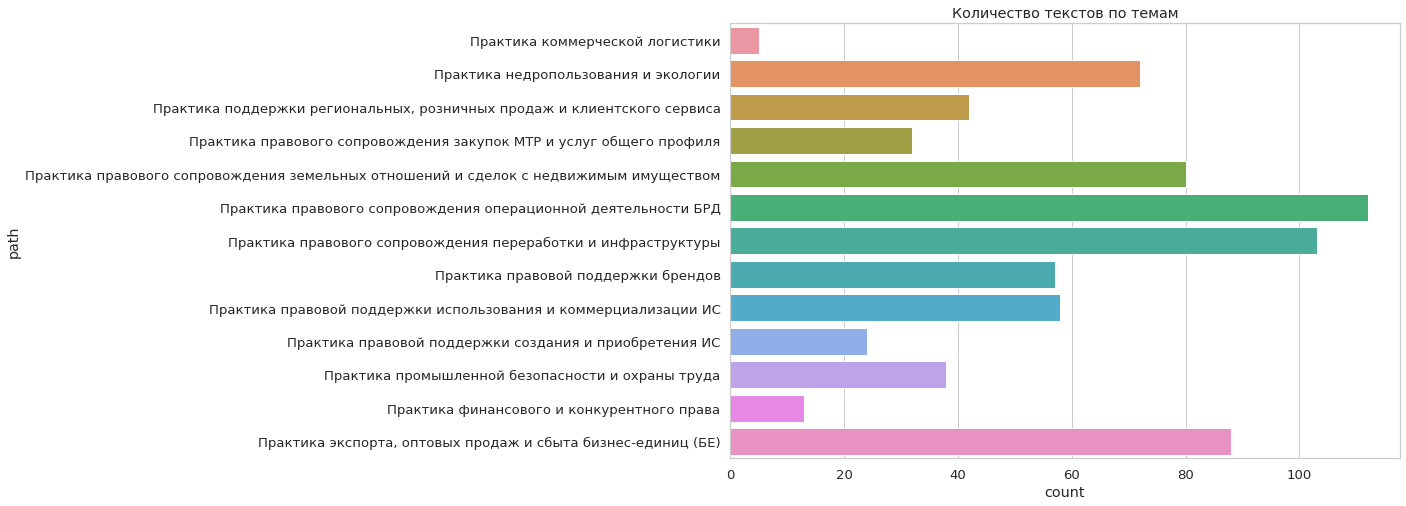

In [124]:
sns.countplot(data=df[training_columns], y='path')
plt.title("Количество текстов по темам")

In [131]:
df['text'][2]

'2.1. В соответствии с условиями настоящего Договора Заказчик поручает, а Исполнитель принимает на себя обязанности оказать Заказчику следующую совокупность услуг:_x000D_\n2.1.1. Организация приема нефтепродуктов Заказчика (в дальнейшем «Груз») путем прямого слива Груза в порту Архангельск (в дальнейшем «Место погрузки») с вагонов-цистерн Заказчика в танкер Исполнителя._x000D_\n2.1.2. Перевозка Груза в танкере Исполнителя по маршруту порт Архангельск – порты Чукотского автономного округа (Певек и Анадырь) в период летней арктической навигации с доставкой и выдачей Груза указанному Заказчиком грузополучателю в конечный порт (Анадырь) не позднее 01 октября 2021 года._x000D_\n2.2. Стороны определили период оказания услуг по настоящему Договору с 01 июня 2021 года по 31 декабря 2021 года._x000D_\n2.3. Объем перегружаемого и перевозимого Груза, в том числе топливо для реактивных двигателей марки ТС-1 в период, определенный Сторонами в пункте 2.2 настоящего Договора, составляет до 1\xa0000 т

In [210]:
!pip install datasets
!pip install -U scikit-learn
!pip3 install torch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Using cached torch-1.10.0-

In [173]:
import datasets
categories = categories.tolist()
# datasets.ClassLabel(names=categories)

ClassLabel(num_classes=13, names=['Практика коммерческой логистики', 'Практика недропользования и экологии', 'Практика поддержки региональных, розничных продаж и клиентского сервиса', 'Практика правового сопровождения закупок МТР и услуг общего профиля', 'Практика правового сопровождения земельных отношений и сделок с недвижимым имуществом', 'Практика правового сопровождения операционной деятельности БРД', 'Практика правового сопровождения переработки и инфраструктуры', 'Практика правовой поддержки брендов', 'Практика правовой поддержки использования и коммерциализации ИС', 'Практика правовой поддержки создания и приобретения ИС', 'Практика промышленной безопасности и охраны труда', 'Практика финансового и конкурентного права', 'Практика экспорта, оптовых продаж и сбыта бизнес-единиц (БЕ)'], names_file=None, id=None)

In [188]:
import tensorflow as tf
from datasets import Dataset
categories_feature=datasets.ClassLabel(names=categories)
features = datasets.Features({'path': categories_feature})

dataset = Dataset.from_pandas(df[training_columns])

In [189]:
dataset

Dataset({
    features: ['path', 'text', '__index_level_0__'],
    num_rows: 724
})

In [192]:
dataset.features

{'path': Value(dtype='string', id=None),
 'text': Value(dtype='string', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

In [194]:
def convert_to_class_label(row):
    row['path'] = categories_feature.str2int(row['path'])
    return row
updated_dataset = dataset.map(convert_to_class_label)

  0%|          | 0/724 [00:00<?, ?ex/s]

### casting features

In [198]:
updated_dataset.features

{'path': ClassLabel(num_classes=13, names=['Практика коммерческой логистики', 'Практика недропользования и экологии', 'Практика поддержки региональных, розничных продаж и клиентского сервиса', 'Практика правового сопровождения закупок МТР и услуг общего профиля', 'Практика правового сопровождения земельных отношений и сделок с недвижимым имуществом', 'Практика правового сопровождения операционной деятельности БРД', 'Практика правового сопровождения переработки и инфраструктуры', 'Практика правовой поддержки брендов', 'Практика правовой поддержки использования и коммерциализации ИС', 'Практика правовой поддержки создания и приобретения ИС', 'Практика промышленной безопасности и охраны труда', 'Практика финансового и конкурентного права', 'Практика экспорта, оптовых продаж и сбыта бизнес-единиц (БЕ)'], names_file=None, id=None),
 'text': Value(dtype='string', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

In [197]:
from datasets import ClassLabel, Value
new_features = updated_dataset.features.copy()
new_features["path"] = ClassLabel(names=categories)

updated_dataset = updated_dataset.cast(new_features)

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [200]:
updated_dataset=updated_dataset.shuffle(seed=42)
updated_dataset['path'][:5]

[6, 4, 5, 7, 5]

In [201]:
work_dataset = updated_dataset.train_test_split(test_size=0.1)
work_dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'text', '__index_level_0__'],
        num_rows: 651
    })
    test: Dataset({
        features: ['path', 'text', '__index_level_0__'],
        num_rows: 73
    })
})

## Metric

In [151]:
from datasets import load_dataset, load_metric
metric = load_metric('glue','mrpc')

pp.pprint(metric)

Metric(name: "glue", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = datasets.load_metric('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=references)
    >>> print(res

## Preprocessing data

In [79]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [152]:
tokenizer("""2.1. В соответствии с условиями настоящего Договора Заказчик поручает, а Исполнитель принимает на себя обязанности оказать Заказчику следующую совокупность услуг:
""")

{'input_ids': [1, 22, 18, 21, 18, 378, 7529, 280, 32863, 11388, 20429, 264, 5229, 340, 1445, 4935, 456, 16, 376, 37569, 540, 11688, 324, 830, 10044, 15236, 5229, 340, 15963, 15958, 40612, 7573, 30, 203, 22, 18, 21, 18, 21, 18, 14841, 9218, 18609, 28718, 18054, 733, 5229, 340, 5376, 534, 284, 10829, 440, 934, 1426, 7240, 6872, 22451, 8040, 264, 32565, 1050, 281, 24300, 23803, 334, 534, 284, 10829, 440, 746, 27155, 8326, 446, 7240, 280, 30957, 17, 326, 2565, 268, 5229, 340, 5376, 281, 2527, 7769, 37569, 1611, 18, 203, 22, 18, 21, 18, 22, 18, 14990, 394, 428, 32565, 1050, 281, 17828, 1399, 37569, 1611, 341, 31463, 3871, 23803, 334, 588, 47242, 682, 47284, 755, 13887, 458, 10513, 534, 613, 375, 383, 289, 1088, 3492, 1937, 13, 281, 3500, 43792, 46553, 1708, 37928, 4103, 280, 3634, 748, 289, 12295, 13717, 32565, 1050, 2562, 13154, 5229, 340, 8695, 3761, 7257, 8548, 281, 7012, 465, 3871, 534, 4375, 3492, 1937, 13, 332, 9027, 33345, 4453, 889, 6804, 884, 18, 203, 22, 18, 22, 18, 20174, 1159, 3

In [202]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, max_length=512)


In [203]:
pre_tokenizer_columns = set(work_dataset["train"].features)
encoded_dataset = work_dataset.map(preprocess_function, batched=True)
tokenizer_columns = list(set(encoded_dataset["train"].features) - pre_tokenizer_columns)
print("Columns added by tokenizer:", tokenizer_columns)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Columns added by tokenizer: ['input_ids', 'attention_mask']


In [204]:
encoded_dataset["train"].features["path"]

ClassLabel(num_classes=13, names=['Практика коммерческой логистики', 'Практика недропользования и экологии', 'Практика поддержки региональных, розничных продаж и клиентского сервиса', 'Практика правового сопровождения закупок МТР и услуг общего профиля', 'Практика правового сопровождения земельных отношений и сделок с недвижимым имуществом', 'Практика правового сопровождения операционной деятельности БРД', 'Практика правового сопровождения переработки и инфраструктуры', 'Практика правовой поддержки брендов', 'Практика правовой поддержки использования и коммерциализации ИС', 'Практика правовой поддержки создания и приобретения ИС', 'Практика промышленной безопасности и охраны труда', 'Практика финансового и конкурентного права', 'Практика экспорта, оптовых продаж и сбыта бизнес-единиц (БЕ)'], names_file=None, id=None)

In [205]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")


tf_train_dataset = encoded_dataset["train"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["path"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)
tf_validation_dataset = encoded_dataset["test"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["path"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

## Fine-tuning the model

In [211]:
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
num_labels = categories_feature.num_classes

model = TFAutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=num_labels, from_pt=True
)

2021-12-10 08:04:55.887256: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 196.35MiB (rounded to 205885440)requested by op AddV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2021-12-10 08:04:55.887274: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2021-12-10 08:04:55.887281: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 10, Chunks in use: 10. 2.5KiB allocated for chunks. 2.5KiB in use in bin. 298B client-requested in use in bin.
2021-12-10 08:04:55.887284: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 1, Chunks in use: 1. 768B allocated for chunks. 768B in use in bin. 584B client-requested in use in bin.
2021-12-10 08:04:55.887287: I tensorflow/core/

ResourceExhaustedError: Exception encountered when calling layer "roberta" (type TFRobertaMainLayer).

failed to allocate memory [Op:AddV2]

Call arguments received:
  • input_ids=tf.Tensor(shape=(3, 5), dtype=int32)
  • attention_mask=None
  • token_type_ids=None
  • position_ids=None
  • head_mask=None
  • inputs_embeds=None
  • encoder_hidden_states=None
  • encoder_attention_mask=None
  • past_key_values=None
  • use_cache=None
  • output_attentions=False
  • output_hidden_states=False
  • return_dict=True
  • training=False
  • kwargs=<class 'inspect._empty'>